In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
import requests
from urllib.parse import urlencode

from scipy import stats
from scipy.stats import norm
from scipy.stats import chi2_contingency

%matplotlib inline

# 1 Задание
В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [2]:
public_key = ['https://disk.yandex.ru/d/DHBVch_HKdfv0Q',
              'https://disk.yandex.ru/d/UCH14IszZDYt9Q',
              'https://disk.yandex.ru/d/VUAKNevy43kYsA',
              'https://disk.yandex.ru/d/5tD11aBs1qBJ3Q'] 

# Создаем ссылку для скачивания
final_link = []
for i in public_key:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=i))
    response = requests.get(final_url)
    df = response.json()['href']
    download_response = requests.get(final_url)
    final_link.append(df)

In [3]:
# загрузка файлов

a_studs = pd.read_csv(final_link[0])
checks = pd.read_csv(final_link[1], sep=';')
groups_add = pd.read_csv(final_link[2])
groups = pd.read_csv(final_link[3], sep=';')

1. Для начала, посмотрим на данные, чтобы иметь первоначальное представление о том какие метрики будем исследовать.

In [4]:
print(groups.head(), '\n')
print(groups.info())

     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None


In [5]:
groups['id'].nunique()#кол-во значений совпадает с кол-м уникальных значений в id => все id уникальны

74484

In [6]:
print(groups_add.head(), '\n')
print(groups_add.info())

        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None


In [7]:
groups_add['id'].nunique() #кол-во значений совпадает с кол-м уникальных значений в id => все id уникальны

92

In [8]:
#проверим есть ли одинаковые id  в 2х группах
groups_add['id'].isin(groups['id']).sum()

0

In [9]:
print(a_studs.head(), '\n')
print(a_studs.info())

   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None


In [10]:
a_studs.nunique()

student_id    8341
dtype: int64

In [11]:
print(checks.head(), '\n')
print(checks.info())

   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None


In [12]:
checks['student_id'].nunique()

541

Дано: 
 - 2 группы студентов (A и B)
 - Новая механика оплаты
 - Провели механику на одной из групп

Задание: Проанализировать итоги эсперимента и сделать вывод

Метрики для анализа:
CR - коэффициент конверсии. Здесь нам будет интересно увидеть как изменилась данная метрика при изменении механики. Это основная метрика для анализа, т.к непосредственно данная метрика покажет изменения(если они есть) при исследовании.  
ARPU - средний доход с привлеченного пользователя
ARPPU - средний доход с клиента. 
Эти две метрики мы возьмем чтобы смотреть не изменился ли доход(если изменился) на пользователя в рамках эксперимента.


#соеденим 2 группы, проверим на дубли
groups_full = pd.concat([groups, groups_add])
print('Дублей:', groups_full['id'].duplicated().sum())
print('Кол-во строк:',groups_full.shape[0])

groups_full.groupby('grp').size()#сильные различия по кол-ву участников в группах. Для теста желательно чтобы кол-во исследуемых элементов было примерно одинаковым

In [13]:
# Объединение групп и активных студентов
template = groups.merge(a_studs, how='left', left_on='id', right_on='student_id')

# Объединение с проверками
template = template.merge(checks, how='left', left_on='id', right_on='student_id')

# Удаление ненужного столбца и переименование
template = template.drop('student_id_y', axis=1).rename(columns={"student_id_x": "active"})

# Заполнение пропущенных значений нулями
template = template.fillna(0)

# Преобразование столбца 'active' в 1 или 0
template['active'] = template['active'].apply(lambda x: 1 if x > 0 else 0)

In [14]:
template.head()

,id,grp,active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


In [16]:
# Фильтрует данные в template по условию, где значение столбца active равно 1. То есть, оставляем только те строки, где пользователь активен.
# Группируем по группам и делаем аггрегацию: считаем кол-во активн пользователей в эксперименте для каждой группы
# CR, средний чек и средний чек на платящего пользователя
template = template[template['active'] == 1]
grouped_data = template.groupby('grp', as_index=False).agg(
    count_of_ids=('id', 'count'),
    CR=('rev', lambda x: np.mean(x > 0)),
    ARPU=('rev', 'mean'),
    ARPPU=('rev', lambda x: np.mean(x.loc[x > 0])))

In [17]:
grouped_data

,grp,count_of_ids,CR,ARPU,ARPPU
0,A,1535,0.050814,47.439739,933.589744
1,B,6793,0.046077,57.864567,1255.827487


In [18]:
template.head()

,id,grp,active,rev
1,1627,A,1,990.0
10,2085,B,1,0.0
12,2215,B,1,0.0
43,3391,A,1,0.0
45,3401,B,1,0.0


Text(0.5, 1.0, 'Распределение кол-ва оплат по суммам')

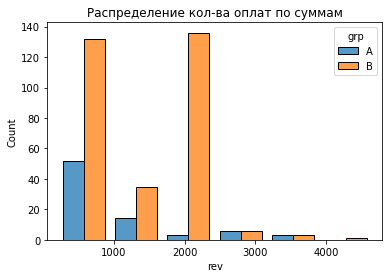

In [23]:
#посмотрим как распределилось кол-во оплат по ценам в исследуемых группах
template_filtered = template[(template['rev'] > 0)]  # Фильтрация данных по условиям rev > 0
sns.histplot(data=template_filtered, x="rev", hue="grp", multiple="dodge", shrink=.8, bins=6)
plt.title('Распределение кол-ва оплат по суммам')

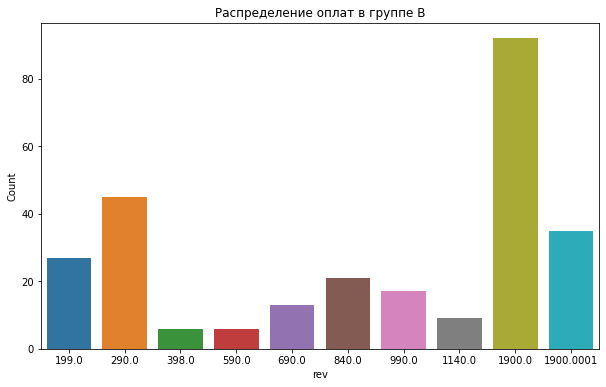

In [24]:
# в тестовой группе есть выброс в покупках на сумму 1900р.:

data = template.query('rev > 0 and grp == "B" and active == 1').rev.value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=data.index, y=data.values)
plt.xlabel('rev') 
plt.ylabel('Count')
plt.title('Распределение оплат в группе B')
plt.show()


Похоже, что рост средних метрик ARPU и ARPPU может быть связан с выбросом в виде покупок по цене 1900. В остальном распределения метрик очень похожи. Это может указывать на действие маркетинга, которая повлияла только на клиентов в тестовой группе. Здесь требуется доп. информация. Без этой информации проведение тестов может привести к серьезным ошибкам в выводах.

Основывая на этих данных оценивать различия в метриках ARPU и ARPPU имеет мало смысла, так как мы фокусировались на оценке новой механики оплаты. Более логичным и важным для нас является оценка конверсии в оплату (CR), которая фактически уменьшилась в тестовой группе. Тем не менее, проведем статистические тесты, чтобы проверить, есть ли статистическая значимость в этих различиях.

Для проверки разницы в конверсии между группами будем использовать непараметрический критерий хи-квадрат.

H0 - cr не изменился.
H1 - cr измениля.
α = 0,05
Разобьем группы пользователей на оплативших и не оплативших.

In [186]:
#созадим табл на основе котороый сделае тест
сhi_table = pd.crosstab(template[template['active']==1].grp, template.rev > 0)
сhi_table.rename(columns={False: 'Not_buy', True: 'Buy'})

rev,Not_buy,Buy
grp,,
A,1457,78
B,6480,313


In [187]:
chi2, p, dof, ex = chi2_contingency(сhi_table)
print(f"p-value: {p}")

p-value: 0.46803677583199144


Вывод:

p - value существенно выше α. Не отклоняем H0 гипотезу, стат значимой разницы между cr исследуемых групп нет.
Данную механику не запускаем

# Задание 2.1

Необходимо написать запрос, который даст информацию о количестве очень усердных студентов.
Под усердным студентом будем понимать студента, который правильно решил 20 задач за текущий месяц.

In [30]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student',
                      'password': 'dpo_python_2020'
                      }

In [31]:
# пишем подзапрос для расчета уникальных студентов кол-во действий в сек и фильтруем 
# по тем у кого уник действий больше чем 1
# далее группируем все по st_id и фильтруем по кол-ву правильно решивших 20 и более задач
q_1 = '''

SELECT COUNT(DISTINCT st_id) As total_st
FROM (SELECT
            st_id,                                           
            COUNT(DISTINCT st_id) AS total_st,
            SUM(correct_mark) AS total_corr_task
    FROM    (SELECT
                DISTINCT st_id AS st_id,
                timest,
                groupArray(subject) AS sub_list,
                COUNT(subject) AS num_subj,
                COUNT(correct) AS num_task,
                COUNT(DISTINCT correct) AS num_correct,
                SUM(correct) AS correct_mark
            FROM default.peas                    
            GROUP BY st_id, timest
            HAVING     num_task < 2
                   AND num_correct < 2 
                   AND num_subj < 2                          
            ORDER BY num_task DESC, num_correct DESC)
    GROUP BY st_id
    HAVING total_corr_task >= 20)
'''

In [32]:
query1 = ph.read_clickhouse(query=q_1, connection=connection_default)
query1

,total_st
0,136


# Задание 2.2

Дана таблицы

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.


In [42]:
q_2 = '''
select 
    test_grp,
    ROUND(sum(money)/uniqExact(studs.st_id), 2) as ARPU,
    ROUND(sumIf(money, total_peas > 10)/uniqIf(studs.st_id, total_peas > 10), 2) as ARPAU,
    ROUND(uniqIf(studs.st_id, money > 0)/uniqExact(studs.st_id), 2) as CR,
    ROUND(uniqIf(studs.st_id, money > 0 AND total_peas > 10)/uniqIf(studs.st_id, total_peas > 10), 2) as CR_A,
    ROUND(uniqIf(studs.st_id, money > 0 AND peas_by_math > 1 and subject = 'Math')/uniqIf(studs.st_id, peas_by_math > 1), 2) as CR_A_math

from
  default.studs
  left join (
    select
      st_id,
      subject,
      money
    from
      default.final_project_check

  ) as checks ON studs.st_id = checks.st_id
  left join (
    select
      st_id,
      SUM(correct) as total_peas,
      SUMIf(correct, subject = 'Math') as peas_by_math
    from
      default.peas
    group by
      st_id
  ) as peas ON studs.st_id = peas.st_id
group by test_grp
'''

In [43]:
query2 = ph.read_clickhouse(query=q_2, connection=connection_default)
query2

,test_grp,ARPU,ARPAU,CR,CR_A,CR_A_math
0,control,4540.98,10393.70,0.05,0.11,0.06
1,pilot,11508.47,29739.58,0.11,0.26,0.10


# Задание 3.1

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [193]:
def get_metrics(groups, groups_add, a_studs, checks):
    groups_add.columns = groups.columns
    groups = pd.concat([groups, groups_add])
    template = groups.merge(a_studs, how='left', left_on='id', right_on='student_id') \
              .merge(checks, how='left', left_on='id', right_on='student_id').drop('student_id_y', axis=1) \
              .rename(columns={"student_id_x": "active"}) \
              .fillna(0)

    template['active'] = template['active'].apply(lambda x: 1 if x > 0 else 0)

    result = template[template['active'] == 1].groupby('grp', as_index=False).agg(
        count_of_ids=('id', 'count'),
        ARPU=('rev', 'mean'),
        ARPPU=('rev', lambda x: np.mean(pd.Series(x).loc[lambda x: x > 0])),
        CR=('rev', lambda x: np.mean(x > 0))
    )

    return result

In [194]:
params = get_metrics(groups, groups_add, a_studs, checks)
params

,grp,count_of_ids,ARPU,ARPPU,CR
0,A,1538,47.347204,933.589744,0.050715
1,B,6803,58.058798,1257.878992,0.046156


# Задание 3.2

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [203]:
def get_metrics_chart(params):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

    colors = ['red', 'blue']

    axs[0].bar(params.grp, params.ARPU, color=colors, alpha=0.6)
    axs[0].set_title('ARPU')

    axs[1].bar(params.grp, params.ARPPU, color=colors, alpha=0.6)
    axs[1].set_title('ARPPU')

    axs[2].bar(params.grp, params.CR, color=colors, alpha=0.6)
    axs[2].set_title('CR')

    plt.show()


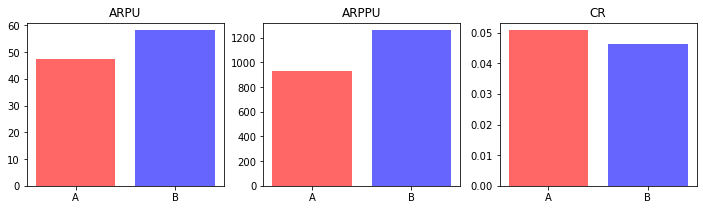

In [204]:
get_metrics_chart(params)